> 스태킹은 여러 가지 모델들의 예측값을 최종 모델의 학습 데이터로 사용하는 예측하는 방법

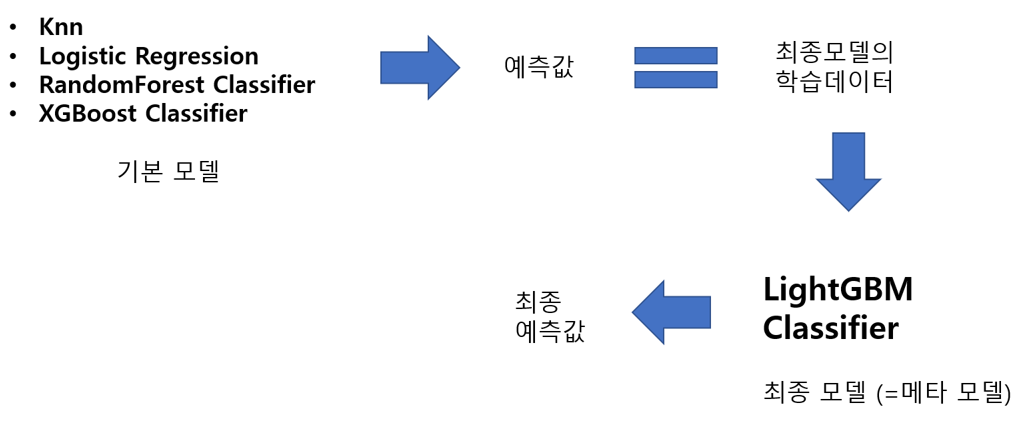

- 이렇게 하면 성능이 무조건 좋아지는가?

- 그건 아닙니다. 현실 모델에서도 많이 사용되지 않는다.
- 다만 성능이 올라가는 경우가 더러 있기 때문에 캐글이나 데이콘과 같은 미세한 성능 차이로 승부를 결정하는 대회에서 주로 사용된다.
- 특히 기본 모델로 4개 이상을 선택해야 좋은 결과를 기대할 수 있다고 한다.

- 기본 모델들을 통해 예측된 값들을 학습용 데이터로 다시 이용한다
> 메타 모델의 모습

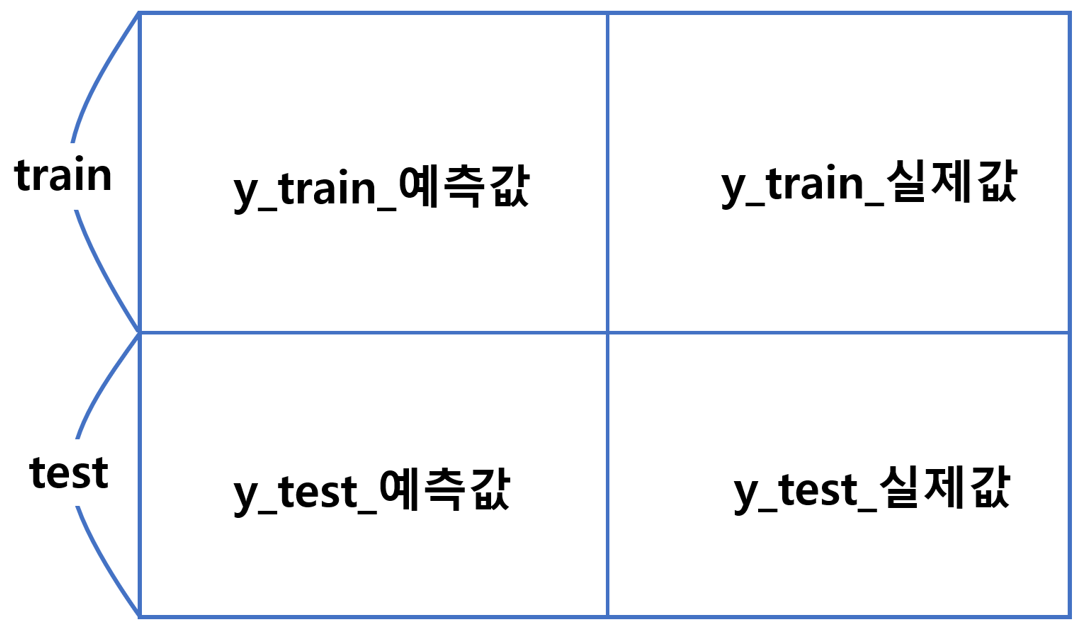

기본 모델들을 통해 'y_train_예측값'과 'y_test_예측값' 데이터프레임을 만들기 => 기본 모델의 예측값들을 옆으로 쭉 붙이기

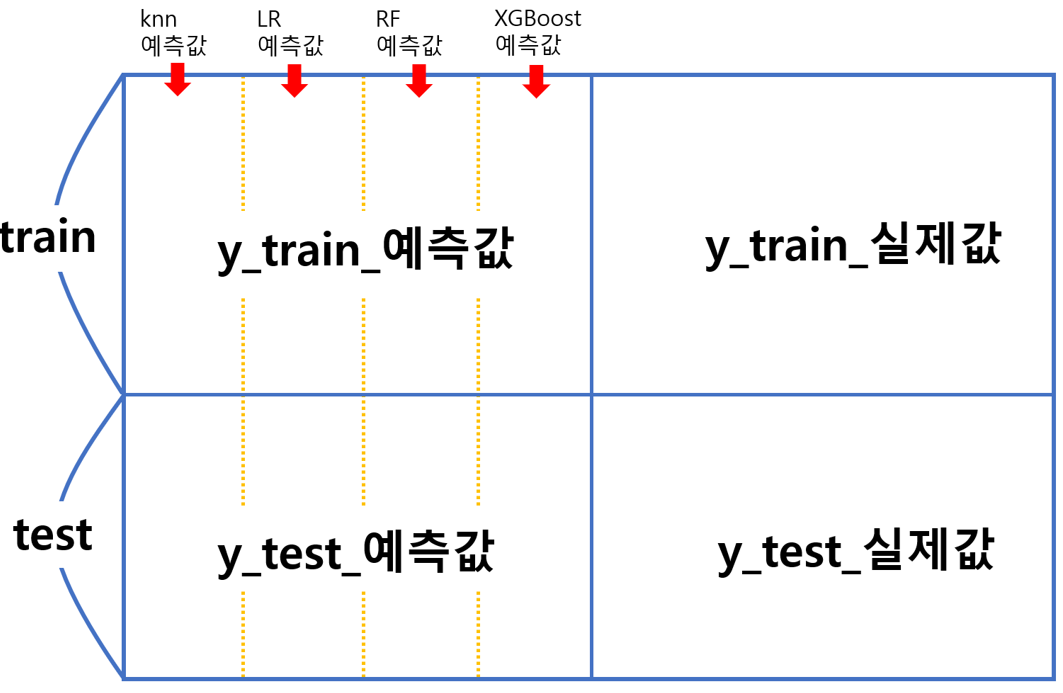

> 최종 모델이 하고자 하는 것은 y 실제값이 이정도 일 때, knn에서 이정도 값, 로지스틱 회귀에서 이정도 값, 랜덤 포레스트에서 이정도 값, XGBoost에서 이정도 값을 예측한다 는 것을 학습시키는 것

[Stacking 스태킹](https://hwi-doc.tistory.com/entry/%EC%8A%A4%ED%83%9C%ED%82%B9Stacking-%EC%99%84%EB%B2%BD-%EC%A0%95%EB%A6%AC)
> 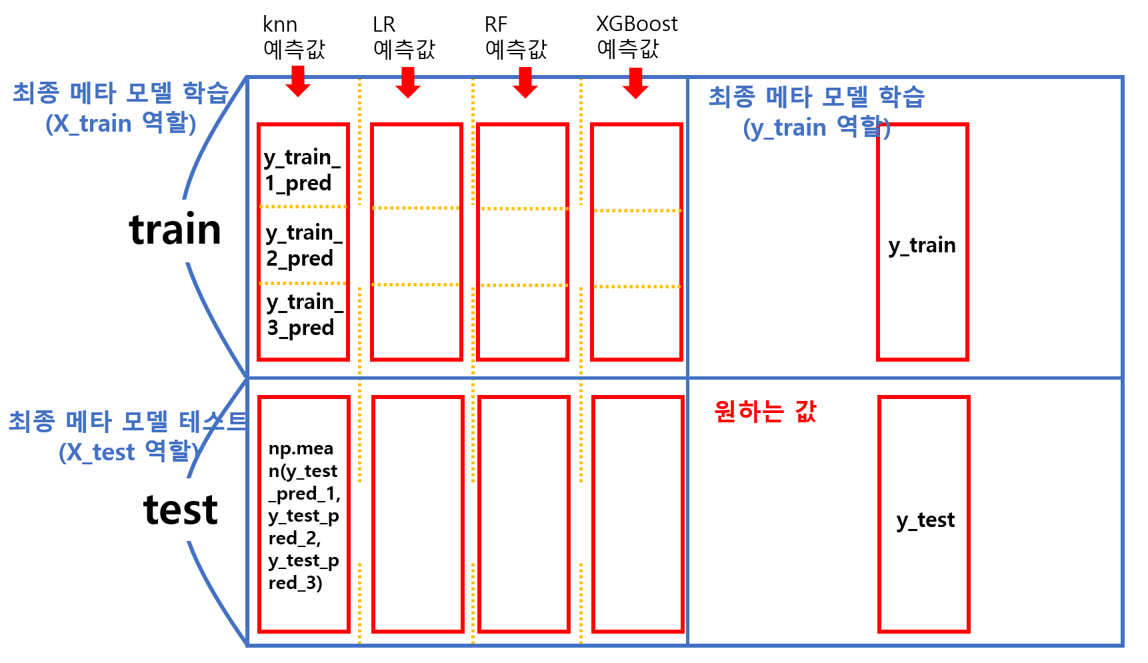

In [2]:
# 기본 스태킹 모델
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

In [3]:
# Stacking에 사용될 머신러닝 알고리즘 클래스 생성하기
# KNN, RandomForest, DecisionTree, AdaBoost => meta model : Logistic Regression
knn_clf = KNeighborsClassifier(n_neighbors = 4)
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators = 100)

lr_final = LogisticRegression()

In [4]:
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [6]:
# 각각의 개별 model들이 반환하는 예측 data set를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)
print('KNN 정확도 : {0:4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} '.format(accuracy_score(y_test, ada_pred)))

KNN 정확도 : 0.921053
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561 


In [8]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

import numpy as np
# 행과 열을 바꿔준다!
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [10]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print(' 최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, final)))
# 메타 모델인 로지스틱 회귀 모델을 학습할 때, 레이블 데이터 세트로 학습 데이터가 아닌 test용 label data set을 기반으로 예측한 값들을 train으로, test 레이블 data를 정답값으로 학습을 시켰다.
# 이러면 과적합 문제가 발생할 수 있다.

 최종 메타 모델의 예측 정확도 : 0.9737


### **과적합을 방지하기 위한 CV set 기반의 Stacking**



In [15]:
# step1 part
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
  kf = KFold(n_splits = n_folds, shuffle = False)
  # 추후 meta model이 사용할 학습 data 반환을 위한 numpy 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작 ')

# enumerate()
# 순서가 있는(iterable) 자료형(예: 리스트, 튜플, 문자열)을 입력으로 받아 인덱스와 해당 값으로 이루어진 튜플을 반환
# 반복문에서 인덱스와 값을 함께 사용할 때 유용

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    print('\t 폴드 세트 : ', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    model.fit(X_tr, y_tr)
    train_fold_pred[valid_index, : ] = model.predict(X_te).reshape(-1,1)
    test_pred[:, folder_counter] = model.predict(X_test_n)

  test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1,1)

  return train_fold_pred, test_pred_mean

In [16]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작 
	 폴드 세트 :  0 시작
	 폴드 세트 :  1 시작
	 폴드 세트 :  2 시작
	 폴드 세트 :  3 시작
	 폴드 세트 :  4 시작
	 폴드 세트 :  5 시작
	 폴드 세트 :  6 시작
RandomForestClassifier model 시작 
	 폴드 세트 :  0 시작
	 폴드 세트 :  1 시작
	 폴드 세트 :  2 시작
	 폴드 세트 :  3 시작
	 폴드 세트 :  4 시작
	 폴드 세트 :  5 시작
	 폴드 세트 :  6 시작
DecisionTreeClassifier model 시작 
	 폴드 세트 :  0 시작
	 폴드 세트 :  1 시작
	 폴드 세트 :  2 시작
	 폴드 세트 :  3 시작
	 폴드 세트 :  4 시작
	 폴드 세트 :  5 시작
	 폴드 세트 :  6 시작
AdaBoostClassifier model 시작 
	 폴드 세트 :  0 시작
	 폴드 세트 :  1 시작
	 폴드 세트 :  2 시작
	 폴드 세트 :  3 시작
	 폴드 세트 :  4 시작
	 폴드 세트 :  5 시작
	 폴드 세트 :  6 시작


In [17]:
# Step2 구현 시작
# Numpy Concatenate를 이용해 이전 함수의 호출로 반환된 각 모델 별 학습 data와 test data를 합쳐준다.
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis = 1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis = 1)
print('원본 학습 피처 data shape : ', X_train.shape, '원본 테스트 피처 shape : ', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,'스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)


원본 학습 피처 data shape :  (455, 30) 원본 테스트 피처 shape :  (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [18]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
